# Calculate item and category reactivation statistics

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
from mindstorm import statplot
from bender_study import task
from bender_study import rsa

bids_dir = Path(os.environ['BENDER_BIDS'])
res_dir = Path(os.environ['BENDER_RESULTS'])
fig_dir = Path(os.environ['BENDER_FIGURES']) / 'plots'

react_dir = res_dir / 'batch' / 'glm' / 'study_stim2' / 'react'

## Load behavioral study phase data

In [2]:
subjects = task.get_subjects('react')
dfs = [
    (
        task.load_merged_study_events(bids_dir, s)
        .sort_values('group')
        .query('pair_type == "BC"')
    ) for s in subjects
]

## Calculate reactivation statistics for each cluster

In [3]:
# load the pre-exposure to study representational 
# dissimilarity matrix for each ROI and subject
rois = ['RPHC', 'LPRC', 'RIFG', 'pHPC']
analyses = [
    'cat_react_item2', 'cat_react_item2', 'cat_react_item2', 'item_suppress_gvt'
]
clusters = ['rphc', 'lprc', 'rifg', 'phpc']
suffix = 'dil1c'
roi_rdms = rsa.load_roi_rdms(
    react_dir, subjects, rois, analyses, clusters, suffix
)

# calculate average similarity (Fisher z) for each bin of interest
stats = rsa.reactivation_stats(subjects, roi_rdms, dfs)

In [4]:
# get item and category reactivation in long table format
react = pd.melt(
    stats.reset_index(), 
    id_vars=['roi', 'subject'], 
    value_vars=['item', 'category'], 
    var_name='Contrast', 
    value_name='Reactivation',
)
react['Contrast'] = react['Contrast'].map({'item': 'Item', 'category': 'Category'})

## Test for item and category reactivation

In [5]:
react.groupby(['Contrast', 'roi'])['Reactivation'].apply(pg.ttest, 0)

T  dof alternative     p-val          CI95%  \
Contrast roi                                                               
Category LPRC T-test  0.749883   29   two-sided  0.459366    [-0.0, 0.0]   
         RIFG T-test -1.881758   29   two-sided  0.069941    [-0.0, 0.0]   
         RPHC T-test  2.820018   29   two-sided  0.008571    [0.0, 0.01]   
         pHPC T-test  2.184827   29   two-sided  0.037130    [0.0, 0.01]   
Item     LPRC T-test  3.163217   29   two-sided  0.003645   [0.01, 0.03]   
         RIFG T-test  3.377981   29   two-sided  0.002097    [0.0, 0.02]   
         RPHC T-test  4.126298   29   two-sided  0.000284   [0.01, 0.02]   
         pHPC T-test -2.912150   29   two-sided  0.006838  [-0.03, -0.0]   

                       cohen-d     BF10     power  
Contrast roi                                       
Category LPRC T-test  0.136909    0.252  0.112102  
         RIFG T-test  0.343560    0.919  0.444175  
         RPHC T-test  0.514862    5.133  0.778048  
         pHPC T-test  0.398893    1.519  0.560506  
Item     LPRC T-test  0.577522    10.69  0.863663  
         RIFG T-test  0.616732   17.286  0.903919  
         RPHC T-test  0.753356  101.618  0.978628  
         pHPC T-test  0.531683    6.222  0.803604

In [6]:
react.groupby(['Contrast', 'roi'])['Reactivation'].agg(['mean', 'sem'])

mean       sem
Contrast roi                     
Category LPRC  0.000835  0.001114
         RIFG -0.001127  0.000599
         RPHC  0.008181  0.002901
         pHPC  0.003422  0.001566
Item     LPRC  0.015611  0.004935
         RIFG  0.010759  0.003185
         RPHC  0.013535  0.003280
         pHPC -0.016448  0.005648

## Plot reactivation/suppression by ROI

LINO NOT subset; don't know how to subset; dropped


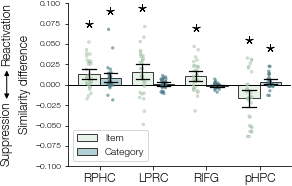

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))

# plot bars and points with significance markers
sig_ind = [0, 1, 2, 4, 6, 7]
statplot.plot_swarm_bar(
    data=react, 
    x='roi', 
    y='Reactivation', 
    hue='Contrast', 
    dodge=True,
    point_kind='strip',
    sig_ind=sig_ind,
    bar_kws=dict(capsize=.25),
    ax=ax,
)

# plot line at zero
xlim = ax.get_xlim()
ax.hlines(0, *xlim, colors=['k']);
ax.set(xlim=xlim, ylim=(-0.1, 0.1), ylabel='Similarity difference')

# add annotation to help with interpretation
prop = dict(
    rotation='vertical', 
    xycoords='axes fraction',
    horizontalalignment='center',
    fontsize='large',
)
xoffset = -0.275
yoffset = 0.1
ax.annotate(
    'Reactivation', 
    xy=(xoffset, 1), 
    verticalalignment='top',
    **prop,
)
ax.annotate(
    'Suppression', 
    xy=(xoffset, 0), 
    verticalalignment='bottom',
    **prop,
)
ax.annotate(
    '', 
    xy=(xoffset, 0.5 - yoffset), 
    xytext=(xoffset, 0.5 + yoffset), 
    arrowprops=dict(arrowstyle="<|-|>", facecolor='k'),
    xycoords='axes fraction',
)
fig.savefig(fig_dir / 'cluster_react_stats.pdf')

## Correlation between item reactivation and suppression

In [8]:
dark = sns.color_palette(
    [
        (1.0000, 0.2784, 0.5647),
        (0.4000, 0.4000, 0.4000),
    ]
)

dark

[(1.0, 0.2784, 0.5647), (0.4, 0.4, 0.4)]

In [9]:
light = sns.color_palette(
    [
        (1.0000, 0.5961, 0.8275),
        (0.8000, 0.8000, 0.8000),
    ]
)
light

[(1.0, 0.5961, 0.8275), (0.8, 0.8, 0.8)]

In [10]:
# use robust regression to estimate coupling
anchor_roi = 'pHPC'
comparison_rois = ['RPHC', 'LPRC', 'RIFG']
corr = pd.concat(
    [
        rsa.item_roi_correlation(subjects, comparison_roi, anchor_roi, roi_rdms, dfs)
        for comparison_roi in comparison_rois
    ], ignore_index=True
)

In [11]:
# average over category, excluding if either undefined
corr_mean = corr.groupby(['correct', 'roi1', 'roi2', 'subject'])['slope'].apply(
    lambda x: x.mean() if x.notna().all() else np.nan
)

In [12]:
sme = corr_mean.loc[1] - corr_mean.loc[0]
sme.groupby('roi1').agg(['mean', 'sem'])

,mean,sem
roi1,,
LPRC,-0.158395,0.045954
RIFG,-0.104053,0.077719
RPHC,-0.133539,0.053815


In [13]:
ttest = sme.groupby('roi1').apply(pg.ttest, 0)
ttest

,,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
roi1,,,,,,,,,
LPRC,T-test,-3.446857,19,two-sided,0.002702,"[-0.25, -0.06]",0.770741,15.497,0.904582
RIFG,T-test,-1.338830,19,two-sided,0.196425,"[-0.27, 0.06]",0.299372,0.505,0.246255
RPHC,T-test,-2.481443,19,two-sided,0.022607,"[-0.25, -0.02]",0.554867,2.618,0.653489


In [14]:
pg.multicomp(ttest['p-val'].to_numpy(), method='fdr_bh')

(array([ True, False,  True]), array([0.0081063 , 0.1964255 , 0.03391004]))

LINO NOT subset; don't know how to subset; dropped


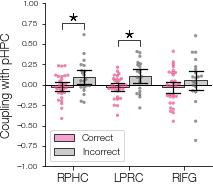

In [15]:
m = corr_mean.reset_index()
m['Inference'] = m['correct'].map({0: 'Incorrect', 1: 'Correct'})

fig, ax = plt.subplots(figsize=(3, 3))
ax = statplot.plot_swarm_bar(
    data=m, 
    x='roi1', 
    y='slope', 
    hue='Inference',
    order=['RPHC', 'LPRC', 'RIFG'], 
    hue_order=['Correct', 'Incorrect'],
    dodge=True,
    sig_diff_ind=[[0, 1], [2, 3]],
    bar_kws=dict(capsize=.25),
    light=light,
    dark=dark,
    ax=ax,
)

# plot line at zero
xlim = ax.get_xlim()
ax.hlines(0, *xlim, colors=['k']);
ax.set(xlim=xlim, ylim=(-1, 1), ylabel='Coupling with pHPC');
fig.savefig(fig_dir / 'cluster_react_coupling.pdf')

In [16]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.3.0

mindstorm   : 0.9.0
matplotlib  : 3.5.1
seaborn     : 0.11.2
bender_study: 0.1.0
pingouin    : 0.5.2
pandas      : 1.4.3
numpy       : 1.22.3

